# Sentiment Analysis with Transformers
In this project, we aim to build a text classification model using natural language processing (NLP) and deep learning techniques to classify IMDB movie reviews as positive or negative. We start by importing the necessary libraries, downloading the dataset, and preprocessing the text by cleaning and tokenizing the reviews. We then split the data into training and validation sets. We create a custom PyTorch dataset class and a BERT-based classifier, incorporating layers for dropout, linear transformation, and batch normalization. We train the model using a binary cross-entropy loss function and an AdamW optimizer, implementing early stopping to prevent overfitting. After training, we evaluate the model's performance and save the best-performing model. Additionally, we extract embeddings from the BERT model and visualize them using t-SNE to observe the separation between positive and negative reviews. This project demonstrates our integration of BERT for embedding generation and PyTorch for building and training the classification model.













## Import related Libraries

In [ ]:
# nlp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel

# others
import os
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

## Loading IMDB Dataset
Here, we define a function to download the IMDB dataset of positive and negative reviews from specified URLs. We retrieve the text data using HTTP requests, split the text into individual reviews, and combine positive and negative reviews into a single list. Corresponding labels (1 for positive and 0 for negative) are also created and returned.



In [ ]:
# Load IMDB dataset

def download_imdb_data():
    pos_url = 'https://raw.githubusercontent.com/dennybritz/cnn-text-classification-tf/master/data/rt-polaritydata/rt-polarity.pos'
    neg_url = 'https://raw.githubusercontent.com/dennybritz/cnn-text-classification-tf/master/data/rt-polaritydata/rt-polarity.neg'
    pos_reviews = requests.get(pos_url).text.split('\n')
    neg_reviews = requests.get(neg_url).text.split('\n')
    reviews = pos_reviews + neg_reviews
    labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)
    return reviews, labels

reviews, labels = download_imdb_data()
print(f'Review: {reviews[0]},\n Label: {labels[0]}')

Review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . ,
 Label: 1


##Data Cleaning
THhen we define a list of English stopwords and a function for cleaning text data. The clean_text function converts text to lowercase, removes non-alphabetic characters, tokenizes the text into words, removes stopwords and short words (less than 3 characters), and finally joins the tokens back into a single string. This preprocessing is crucial for preparing the text data for model training.



In [ ]:
stop_words = stopwords.words('english')

def clean_text(sentence):
  sentence = str(sentence).lower()
  sentence = re.sub('[^a-z]',' ',sentence)
  sentence = word_tokenize(sentence)
  sentence = [i for i in sentence if i not in stop_words]
  sentence = [i for i in sentence if len(i)>2]
  sentence = ' '.join(sentence)
  return sentence

##Splitting Dataset
In this cell, we split the dataset into training and validation sets using an 80-20 split ratio. The train_test_split function from sklearn is used, with reviews and labels as input, ensuring that the data is randomly shuffled and split consistently with a fixed random_state.

Then, The clean_text function is applied to each review in the training and validation sets, effectively preprocessing the text data. This ensures that all reviews are cleaned and ready for further processing or model input



In [ ]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Apply clean text on the reviews
for txt in X_train:
  txt = clean_text(txt)

for txt in X_val:
  txt = clean_text(txt)

##Creating Custom Dataset Class
Here we define a custom PyTorch dataset class, MyDataset, which is used to handle the tokenized text data. The class takes tokenized input (input_ids and attention_mask) and corresponding labels as input during initialization. It implements __getitem__ to retrieve data samples by index and __len__ to return the total number of samples, enabling easy and efficient data handling during model training and evaluation.



In [ ]:
class MyDataset(Dataset):
  def __init__(self, encoded, label):
    self.input_ids = encoded['input_ids']
    self.attention_mask = encoded['attention_mask']
    self.label = label

  def __getitem__(self, index):
    ids = self.input_ids[index]
    masks = self.attention_mask[index]
    lbls = self.label[index]
    return ids, masks, lbls

  def __len__(self):
    return len(self.input_ids)

## Define tokenizer and embedder
Here we initialize the BERT tokenizer and model using the pretrained 'bert-base-uncased' configuration from the transformers library. The tokenizer is used to convert text into token IDs, and the BERT model is set to evaluation mode (eval) to disable dropout layers, preparing it for embedding generation and further model usage.




In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embedder = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
embedder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## Tokenize Clean texts and make dataset
This cell tokenizes the training set reviews using the BERT tokenizer, with padding, truncation, and a maximum length of 100 tokens, and converts the output to PyTorch tensors. It then creates an instance of MyDataset with the tokenized data and labels, and wraps it in a DataLoader to enable batch processing during model training, setting a batch size of 16.



In [ ]:
# Make Train dataset
train_encoded = tokenizer(X_train, padding=True, truncation=True, max_length=100, return_tensors='pt')
trainset = MyDataset(train_encoded, y_train)
train_loader = DataLoader(trainset, batch_size=16)

# Make validation dataset
val_encoded = tokenizer(X_val, padding=True, truncation=True, max_length=100, return_tensors='pt')
valset = MyDataset(val_encoded, y_val)
val_loader = DataLoader(valset, batch_size=16)

##Defining the Model
Here we define a custom classifier model class, Classifier, inheriting from nn.Module. The class initializes with a BERT model for embedding generation and adds additional layers for classification: dropout layers, linear layers, batch normalization layers, and a sigmoid activation function. The forward method defines the forward pass through the network, and the get_embeddings method extracts embeddings from the BERT model without gradient calculations (torch.no_grad()).



In [ ]:
class Classifier(nn.Module):
  def __init__(self, embedder):
    super(Classifier, self).__init__()
    self.bert = embedder
    self.drop1 = nn.Dropout()
    self.fc1 = nn.Linear(768, 8)
    self.drop2 = nn.Dropout(0.8)
    self.batch1 = nn.BatchNorm1d(8)
    self.fc2 = nn.Linear(8, 1)
    self.batch2 = nn.BatchNorm1d(1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids, attention_mask)[1]
    x = self.drop1(x)
    x = self.fc1(x)
    x = self.drop2(x)
    x = self.batch1(x)
    x = self.fc2(x)
    x = self.batch2(x)
    x = self.sigmoid(x)
    return x

  def get_embeddings(self, input_ids, attention_mask):
    # Extract embeddings from BERT
    with torch.no_grad():
        embeddings = self.bert(input_ids, attention_mask=attention_mask)[1]
    return embeddings

model = Classifier(embedder)

##Setting Up Training Components
Here, first we check if a GPU is available and then set the device accordingly (cuda for GPU, cpu otherwise). Second, we transfer the model to the specified device, ensuring that computations are performed on the GPU if available, which accelerates training and inference.

After this, we set up the training components, including the loss function (BCELoss), optimizer (AdamW), training hyperparameters (number of epochs, early stopping patience), and initial values for tracking the best validation loss and epoch. We also create a directory to save the best model checkpoints and initialize lists to store training and validation loss values during training.



In [ ]:
# Transport model to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Loss functiona, Optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=27e-6)

num_epochs = 20
patience = 5  # Number of epochs to wait before stop trainig
best_val_loss = float('inf')
best_epoch = 0

# Directory to save the best model
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)

##Training and Validation Loop
This cell implements the training and validation loop for the model. For each epoch, it performs a training phase where it iterates over the training data loader, performs forward and backward passes, updates the model parameters, and accumulates the training loss. Then, in the validation phase, it iterates over the validation data loader, performs forward passes without gradient calculations (torch.no_grad()), and accumulates the validation loss. It prints the training and validation losses for each epoch and checks if the validation loss has improved. If so, it saves the model checkpoint and updates the best validation loss and epoch. Early stopping is implemented to halt training if no improvement is seen for a specified number of epochs (patience).


In [ ]:
# Lists to store loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train phase
    model.train()
    epoch_train_loss = 0

    for train_input_ids, train_attention_mask, train_labels in train_loader:
        train_input_ids = train_input_ids.to(device)
        train_attention_mask = train_attention_mask.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        outputs = torch.flatten(model(train_input_ids, train_attention_mask))
        loss = criterion(outputs, train_labels.float())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for val_input_ids, val_attention_mask, val_labels in val_loader:
            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)
            val_outputs = torch.flatten(model(val_input_ids, val_attention_mask))
            loss = criterion(val_outputs, val_labels.float())
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    # Check if the validation loss improved for Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        print(f'Best model saved at epoch {epoch + 1}')

    # Check early stopping condition
    if epoch - best_epoch > patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

Epoch [1/20], Training Loss: 0.6640, Validation Loss: 0.5023
Best model saved at epoch 1
Epoch [2/20], Training Loss: 0.5373, Validation Loss: 0.4726
Best model saved at epoch 2
Epoch [3/20], Training Loss: 0.5039, Validation Loss: 0.5077
Epoch [4/20], Training Loss: 0.4878, Validation Loss: 0.4673
Best model saved at epoch 4
Epoch [5/20], Training Loss: 0.4868, Validation Loss: 0.4797
Epoch [6/20], Training Loss: 0.4578, Validation Loss: 0.4814
Epoch [7/20], Training Loss: 0.4444, Validation Loss: 0.4762
Epoch [8/20], Training Loss: 0.4347, Validation Loss: 0.4714
Epoch [9/20], Training Loss: 0.4334, Validation Loss: 0.4608
Best model saved at epoch 9
Epoch [10/20], Training Loss: 0.4285, Validation Loss: 0.4758
Epoch [11/20], Training Loss: 0.4184, Validation Loss: 0.4664
Epoch [12/20], Training Loss: 0.4186, Validation Loss: 0.4783
Epoch [13/20], Training Loss: 0.4134, Validation Loss: 0.4766
Epoch [14/20], Training Loss: 0.4069, Validation Loss: 0.4770
Epoch [15/20], Training Loss:

## Plot Loss function and Learning curve
 Here we ensure that the training and validation loss lists are of equal length by extending the shorter list with its last value. Then we plot the training and validation losses over the epochs using matplotlib.pyplot to visualize the model's performance during training. The plot helps to observe the loss trends and effectiveness of the training process.



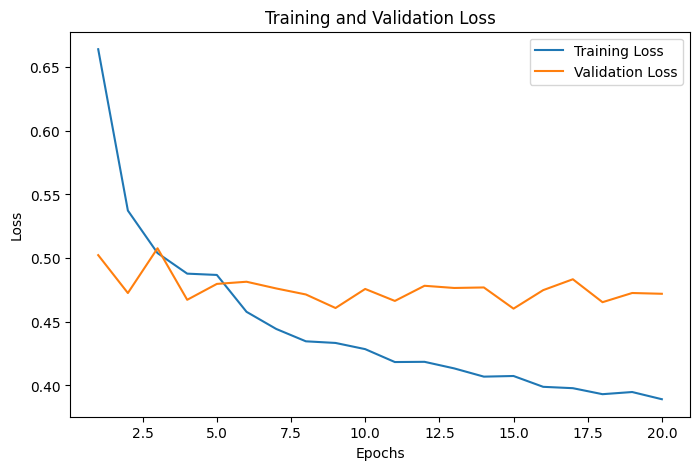

In [ ]:
max_length = max(len(train_losses), len(val_losses))
if len(train_losses) < max_length:
    train_losses.extend([train_losses[-1]] * (max_length - len(train_losses)))
if len(val_losses) < max_length:
    val_losses.extend([val_losses[-1]] * (max_length - len(val_losses)))

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, max_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

##Loading the Best Model and Prediction Phase
This cell loads the best model's saved state from the checkpoint directory, ensuring that the model with the lowest validation loss is used for final evaluation and predictions. This step is crucial for leveraging the best-performing model during the training process.



In [ ]:
# Load the best model
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
print('Best model loaded.')

Best model loaded.


This cell evaluates the model on the validation dataset. It sets the model to evaluation mode and initializes lists to store predictions and true labels. It iterates over the validation data loader, performs forward passes to get model outputs, converts the outputs to binary predictions, and accumulates predictions and labels. Finally, it calculates and prints the accuracy of the model on the validation set.



In [ ]:
# Prediction phase
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_labels in val_loader:
        test_input_ids = test_input_ids.to(device)
        test_attention_mask = test_attention_mask.to(device)
        test_labels = test_labels.to(device)

        outputs = model(test_input_ids, test_attention_mask)

        predicted_classes = (outputs > 0.5).float()

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

correct_predictions = (np.array(all_predictions).flatten() == np.array(all_labels)).sum()
accuracy = correct_predictions / len(all_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8425


## Embedding Extraction and Visualization
At the end, we can extract embeddings for each review in the training set using the get_embeddings method of the classifier model. First, we tokenize each review, transfer the tokenized data to the device, compute the embeddings, and store them along with the corresponding labels in separate lists. These embeddings are later used for visualization.

Then, we combine the extracted embeddings into a single array and reduce their dimensions to 2D using t-SNE for visualization. We also set the perplexity for t-SNE based on the number of embeddings and applies t-SNE transformation. After that, we plot the 2D embeddings using matplotlib.pyplot, coloring the points by their labels (0 or 1) to visualize the separation between classes in the embedding space.



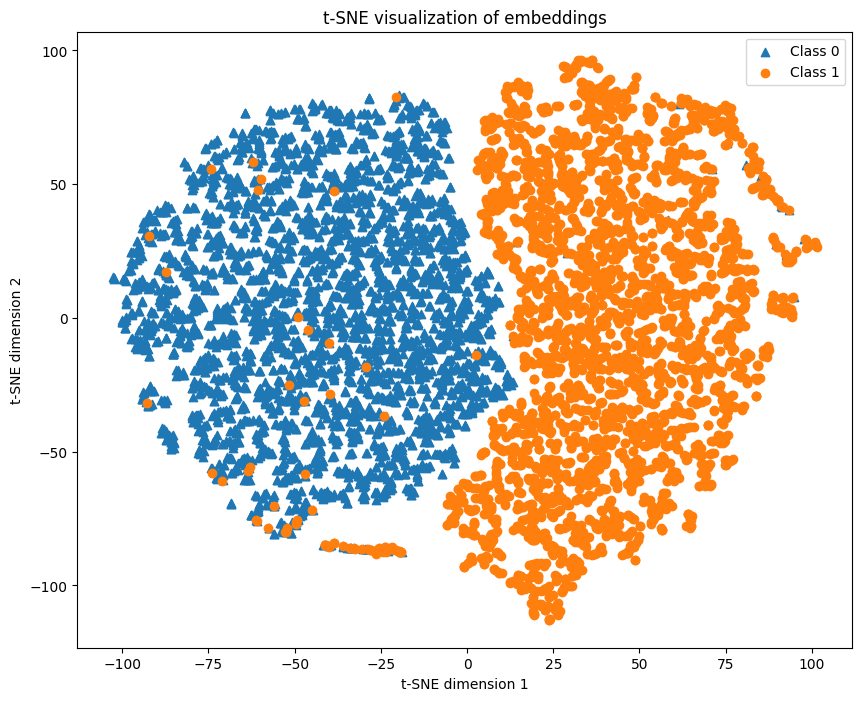

In [ ]:
embeddings = []
labels = []
for text, label in zip(X_train, y_train):
    encoded = tokenizer(text, padding=True, truncation=True, max_length=100, return_tensors='pt')
    ids = encoded['input_ids'].to(device)
    mask = encoded['attention_mask'].to(device)
    embedding = model.get_embeddings(ids, mask)
    if isinstance(embedding, torch.Tensor):
        embedding = embedding.detach().cpu().numpy()
    embeddings.append(embedding)
    labels.append(label)

# Combine embeddings
embeddings = np.vstack(embeddings)
labels = np.array(labels)

# Reduce dimensions using t-SNE with lower perplexity
perplexity = min(5, len(embeddings) - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {label}', marker='^' if label == 0 else 'o')
plt.title('t-SNE visualization of embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()